In [129]:
import functools
import operator

import pandas as pd
import numpy as np

import re
import string
from string import digits

from autocorrect import Speller

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag

import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Data Reading

In [69]:
train_df = pd.read_csv("../dataset/train.csv")
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [70]:
train_df.shape

(27481, 4)

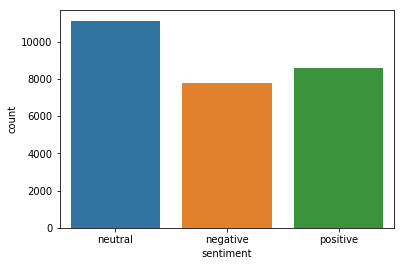

In [71]:
sns.countplot(x="sentiment", data=train_df)

In [72]:
test_df = pd.read_csv("../dataset/test.csv")
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [73]:
test_df.shape

(3534, 3)

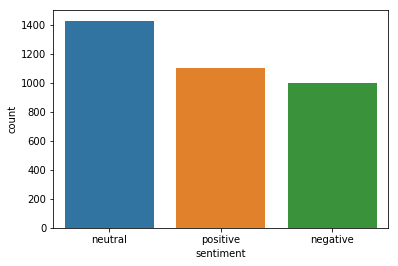

In [74]:
sns.countplot(x="sentiment", data=test_df)

## Preprocessing
    1. Auto correcting words
    2. Removing punctuations and numeric values
    3. Remove all the special characters
    4. Remove all single characters
    5. Remove single characters from the start
    6. Substituting multiple spaces with single space
    7. Removing prefixed 'b'
    8. Converting to Lowercase
    9. Stop word removal
    10. Replace new line character in questions 

In [84]:
spell = Speller(lang='en')

remove_digits = str.maketrans('', '', digits)
translate_table = dict((ord(char), None) for char in string.punctuation)

def punction_and_numeric_value_remover(content):
    return list(filter(None, content.translate(remove_digits).translate(translate_table).split(" ")))

def preprocessor(df):
    preprocessed_df = df.dropna()
    
    # Autocorrect words
    preprocessed_df["text"] = preprocessed_df["text"].apply(lambda x: spell(x))
    
    # Initial preprocessing to remove punctuations and numeric values for generating pos tags
    # Generating POS tags
    preprocessed_df["pos_tags"] = preprocessed_df["text"].apply(lambda x : [(i[0].lower(),i[1]) for i in pos_tag(punction_and_numeric_value_remover(x))])

    # Secondary preprocessing
    X = preprocessed_df["text"].values

    documents = []

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        # Remove digits and punctutations
        document = " ".join(punction_and_numeric_value_remover(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Stop word removal
        document = [word for word in document.split() if word not in stopwords.words('english')]
        document = ' '.join(document)

        documents.append(document)

    preprocessed_df["preprocessed_text"] = documents
    
    return preprocessed_df

In [85]:
preprocessed_train_df = preprocessor(train_df)
preprocessed_test_df = preprocessor(test_df)

c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

## Feature Engineering

### 1. Bag of Words

In [100]:
bow_vectorizer = CountVectorizer(max_features=100, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
bow_train_vector = bow_vectorizer.fit_transform(preprocessed_train_df["preprocessed_text"].values).toarray()
bow_test_vector = bow_vectorizer.fit_transform(preprocessed_test_df["preprocessed_text"].values).toarray()

### 2. Bigrams

In [101]:
bigram_vectorizer = CountVectorizer(max_features=100,ngram_range=(2,2))
bigram_train_vector = bigram_vectorizer.fit_transform(preprocessed_train_df["preprocessed_text"].values).toarray()
bigram_test_vector = bigram_vectorizer.fit_transform(preprocessed_test_df["preprocessed_text"].values).toarray()

### 3. Head words

In [89]:
# Head word tokenizer
nlp = spacy.load("en_core_web_sm")
def head_word_tokenizer(text):
    head_words = []
    for token in nlp(text):
        if token.dep_ == "nsubj" or token.dep_ == "nsubjpass":
            head_words.append(token.text)
            head_words.append(token.head.text)
    return head_words

In [90]:
head_words_vectorizer = CountVectorizer(tokenizer = head_word_tokenizer,max_features=100,stop_words=stopwords.words('english'))
head_words_train_vector = head_words_vectorizer.fit_transform(preprocessed_train_df["text"].values).toarray()
head_words_test_vector = head_words_vectorizer.fit_transform(preprocessed_test_df["text"].values).toarray()

c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve"] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Classifiers

In [91]:
#Confusion Matrix Plotter
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

In [103]:
label_encoder = preprocessing.LabelEncoder()
training_labels =label_encoder.fit_transform(preprocessed_train_df.sentiment.astype(str))
sentiments = train_df.sentiment.unique()
sentiments

array(['neutral', 'negative', 'positive'], dtype=object)

In [119]:
feature_train_vector  = np.hstack([bow_train_vector,bigram_train_vector,head_words_train_vector])
feature_test_vector  = np.hstack([bow_test_vector,bigram_test_vector,head_words_test_vector])

In [120]:
x_train = feature_train_vector
y_train = training_labels
x_test = feature_test_vector
y_test = label_encoder.transform(preprocessed_test_df.sentiment.astype(str))

c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.41171477079796265
              precision    recall  f1-score   support

           0       0.30      0.20      0.24      1001
           1       0.45      0.66      0.54      1430
           2       0.39      0.28      0.33      1103

    accuracy                           0.41      3534
   macro avg       0.38      0.38      0.37      3534
weighted avg       0.39      0.41      0.39      3534



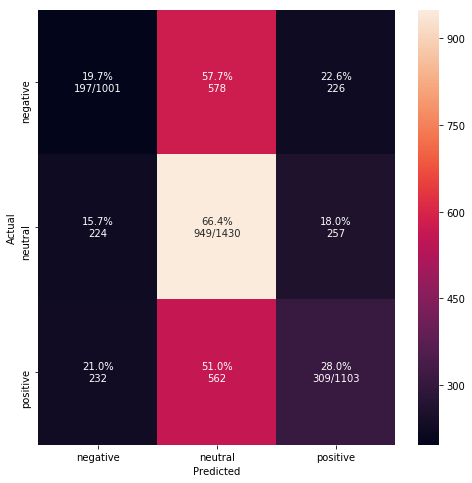

In [122]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

y_pred = logisticRegr.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,))
cm_analysis(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), label_encoder.classes_)

accuracy 0.41709111488398415
              precision    recall  f1-score   support

           0       0.27      0.15      0.19      1001
           1       0.46      0.70      0.55      1430
           2       0.41      0.30      0.35      1103

    accuracy                           0.42      3534
   macro avg       0.38      0.38      0.36      3534
weighted avg       0.39      0.42      0.39      3534



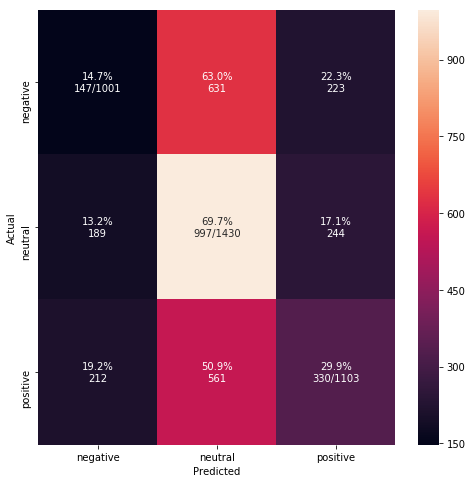

In [123]:
svc = SVC(decision_function_shape='ovo')
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,))
cm_analysis(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), label_encoder.classes_)

In [124]:
wv = api.load('word2vec-google-news-300')

In [125]:
def prepare_mean_embeddings(df):
    mean_embeddings = []
    for sentence in df["preprocessed_text"].values:
        sentence_vec = []
        for word in sentence.split():
            if word not in nltk.corpus.stopwords.words('english'):
                if word in wv.vocab.keys():
                    sentence_vec.append(wv[word])
        if len(sentence_vec) == 0:
            sentence_vec = [[0]*300]
        mean_embeddings.append(np.array(sentence_vec).mean(axis=0))
    return mean_embeddings

mean_embeddings_train = prepare_mean_embeddings(preprocessed_train_df)
mean_embeddings_test = prepare_mean_embeddings(preprocessed_test_df)

c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.6578947368421053
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      1001
           1       0.59      0.73      0.65      1430
           2       0.74      0.64      0.69      1103

    accuracy                           0.66      3534
   macro avg       0.68      0.65      0.66      3534
weighted avg       0.67      0.66      0.66      3534



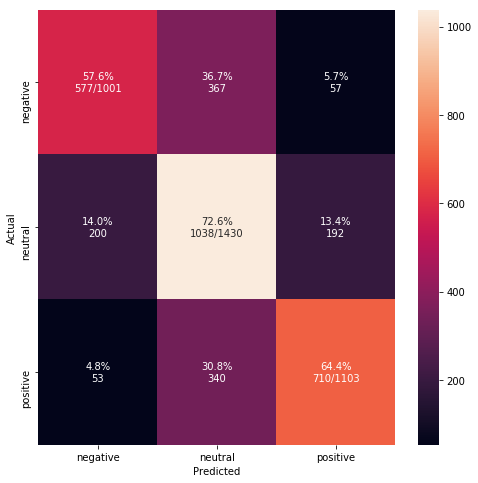

In [126]:
logisticRegr = LogisticRegression()
logisticRegr.fit(mean_embeddings_train, y_train)

y_pred = logisticRegr.predict(mean_embeddings_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,))
cm_analysis(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), label_encoder.classes_)

In [139]:
doc_list  = list(preprocessed_train_df["preprocessed_text"].values) + list(preprocessed_test_df["preprocessed_text"].values)
dictionary = Dictionary()
BoW_corpus = [dictionary.doc2bow(doc.split(), allow_update=True) for doc in doc_list]
tfidf = TfidfModel(BoW_corpus) 

In [140]:
tfidf_word_values = {}
tfidf_word_list = functools.reduce(operator.iconcat, tfidf[BoW_corpus], [])
for m in set(tfidf_word_list):
    tfidf_word_values[dictionary[m[0]]] = m[1]

In [141]:
def prepare_tfidf_mean_embeddings(df):
    tfidf_mean_embeddings = []
    for sentence in df["preprocessed_text"].values:
        sentence_vec = []
        for word in sentence.split():
            if word not in nltk.corpus.stopwords.words('english'):
                if word in wv.vocab.keys():
                    sentence_vec.append(np.array(wv[word]*tfidf_word_values[word]))
        if len(sentence_vec) == 0:
            sentence_vec = [[0]*300]
        tfidf_mean_embeddings.append(np.array(sentence_vec).mean(axis=0))
    return tfidf_mean_embeddings

tfidf_mean_embeddings_train = prepare_tfidf_mean_embeddings(preprocessed_train_df)
tfidf_mean_embeddings_test = prepare_tfidf_mean_embeddings(preprocessed_test_df)

c:\users\pickme1124\pycharmprojects\testing\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.6106395019807583
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      1001
           1       0.55      0.70      0.61      1430
           2       0.67      0.58      0.62      1103

    accuracy                           0.61      3534
   macro avg       0.63      0.60      0.61      3534
weighted avg       0.62      0.61      0.61      3534



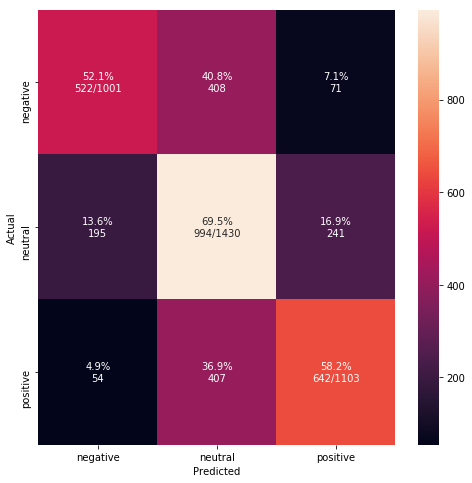

In [142]:
logisticRegr = LogisticRegression()
logisticRegr.fit(tfidf_mean_embeddings_train, y_train)

y_pred = logisticRegr.predict(tfidf_mean_embeddings_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,))
cm_analysis(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), label_encoder.classes_)